In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
#import seaborn as sb
import sympy as s
from tqdm import tqdm
import pickle
from scipy.optimize import minimize as sci_minimize
from scipy.optimize import basinhopping
from scipy.integrate import quad
from scipy import stats
from sympy import pycode
s.init_printing()

In [2]:
# Tunning Curve para o IPD de theta condicionada a phi do neuronio
def g(theta : float, phi_i : float, r_max : float = 1) -> float:
    return r_max * (np.cos((theta - phi_i)/2) + 0.5)**4

# Funcao da informacao de Fisher de um neuronio
# Seu valor de phi eh parametrizado
def fi(phi : np.ndarray, T : float = 1, r_max : float = 1) -> list:
    fs = []
    for phi_i in phi:
        intermediate = lambda p_i : lambda theta : T*r_max*((np.cos(theta - p_i) + 1)**2)*np.sin(theta - p_i)**2
        fs.append(intermediate(phi_i))

    return fs

# Funcao de 1 sobre a Funcao da informacao de Fisher da populacao
# Eh obtida pela soma das funcoes de informacao de fisher para cada valor de phi
def F(theta : float, phi : np.ndarray, T : float = 1, r_max : float = 1) -> float:
    fs = fi(phi, T, r_max)
    return 1/np.sum([f(theta) for f in fs])

# Funcao custo em funcao dos parametros phi da populacao
# obtida pela integracao de 1/F, em que F eh a informacao de Fisher da populacao
# os limites de integracao delimitam o theta
def V(phi : np.ndarray, lim : float, T : float = 1, r_max : float = 1) -> float:
    return quad(F, -lim, lim, args=(phi, T, r_max))[0]

In [3]:
class Experimento():
    def __init__(self, N = 200, tamanho_cabeca = 15e-2, Nfreqs = 50):
        self.N = N

        self.frequencias = np.arange(0, 1501, Nfreqs)[1:]
        self.limites = self.frequencias * 2 * np.pi * (tamanho_cabeca/320.29)

        self.rand =  np.random.rand(self.N)
        self.phi_rand = (-np.pi * self.rand) + np.pi * (1 - self.rand)

        self.thetas = np.arange(-np.pi, np.pi, 0.01)/(2*np.pi)

        self.phi_optimal = None

    def run(self):
        self.phi_optimal = []
        for lim in tqdm(self.limites):
            res = sci_minimize(V, self.phi_rand, (lim, 1, 1), method='Powell')
            if res.success:
                self.phi_optimal.append(res.x)
            else:
                self.phi_optimal.append(self.phi_rand*0)

    def plot(self, lim, t = [], fig = None, ax = None):
        if self.phi_optimal:
            if not np.any(t):
                t = np.copy(self.thetas)
                t = t*2*np.pi

            if not ax:
                fig, ax = plt.subplots(layout="constrained")

            for phi in self.phi_optimal[lim]:
                ax.plot(t, g(t, phi, 1))
                #plt.plot(thetas, [g(thetas, phi, 1) for phi in phis]) #g(thetas, phi, 1)
            ax.vlines(self.limites[lim], 0, 5, 'k')
            ax.vlines(-self.limites[lim], 0, 5, 'k')
            ax.set_title("limite: {:.2f}".format(self.limites[lim]))

    def plotAll(self):
        nGrafs = int(np.ceil(exp.limites.shape[0]/3))
        fig, axs = plt.subplots(nGrafs, 3, layout="constrained")

        t = np.copy(self.thetas)
        t = t*2*np.pi
        for lim, ax in zip(range(self.limites.shape[0]), axs.flat):
            self.plot(lim, t, fig, ax)

        for ax in axs.flat:
            if not ax.has_data():
                ax.set_axis_off()


    def load(self, path):
        file = open(path, 'rb')
        self.phi_optimal = pickle.load(file)
        file.close()
            
    def save(self, name='phi_opt'):
        phi_opt = open(name, 'ab')
        pickle.dump(self.phi_optimal, phi_opt)
        phi_opt.close()
        

In [4]:
exp = Experimento(N=200, tamanho_cabeca=15e-2, Nfreqs=30)
exp.load('./optimization-FI_neural-human_head')

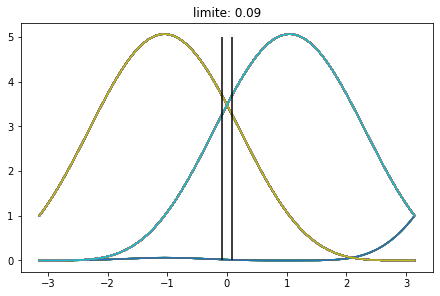

In [5]:
exp.plot(0)

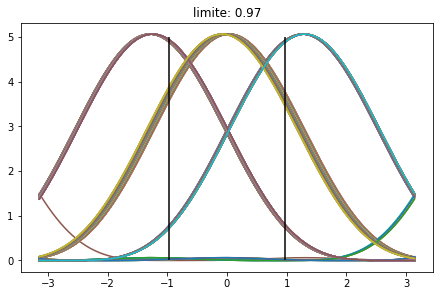

In [9]:
exp.plot(10)

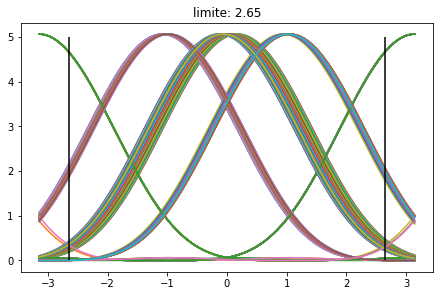

In [10]:
exp.plot(29)

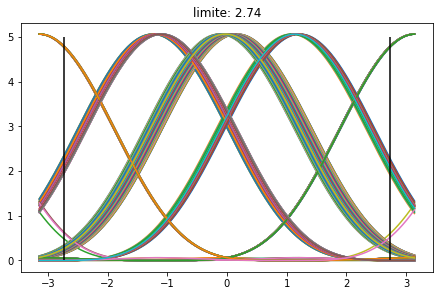

In [11]:
exp.plot(30)

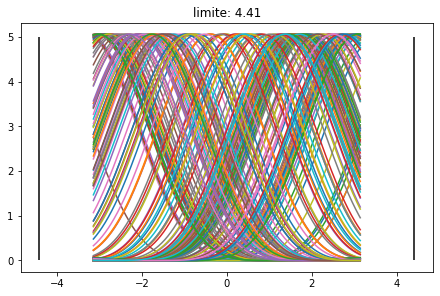

In [13]:
exp.plot(49)

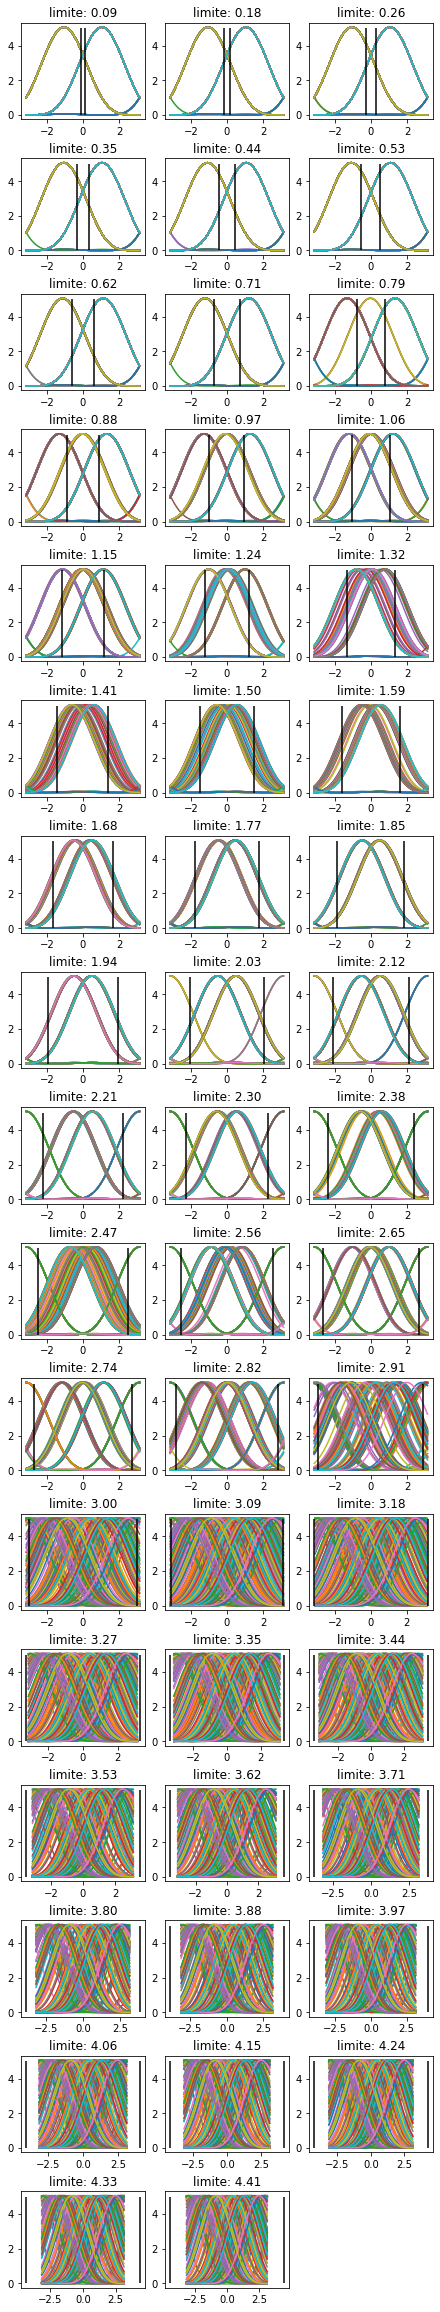

In [14]:
nGrafs = int(np.ceil(exp.limites.shape[0]/3))
fig, axs = plt.subplots(nGrafs, 3, layout='constrained', figsize=(6, 32)) #, figsize=(10, 20)

t = np.copy(exp.thetas)
t = t*2*np.pi
for lim, ax in zip(range(exp.limites.shape[0]), axs.flat):
    for phi in exp.phi_optimal[lim]:
        ax.plot(t, g(t, phi, 1))
        #plt.plot(thetas, [g(thetas, phi, 1) for phi in phis]) #g(thetas, phi, 1)
    ax.vlines(exp.limites[lim], 0, 5, 'k')
    ax.vlines(-exp.limites[lim], 0, 5, 'k')
    ax.set_title("limite: {:.2f}".format(exp.limites[lim]))

for ax in axs.flat:
    if not ax.has_data():
        ax.set_axis_off()

# Extraindo as frequencias e plotando

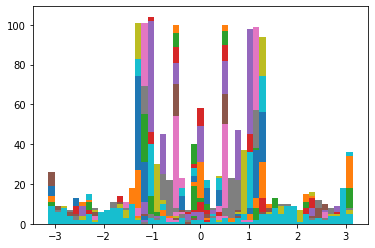

In [161]:
t = np.linspace(-np.pi, np.pi, 50)

x_50 = []
for phi in exp.phi_optimal:
    phi_wrap = (phi+np.pi) % (2*np.pi) - np.pi #wrap to pi
    x, _, _ = plt.hist(phi_wrap, bins=t)
    x_50.append(x)

x_50 = np.asarray(x_50)

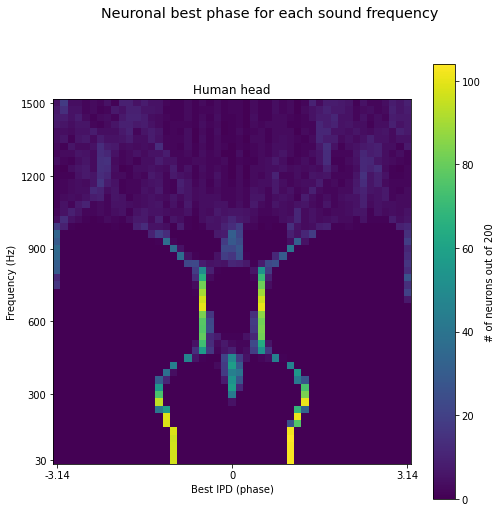

In [235]:
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(np.flip(x_50), cmap='viridis',
               aspect='equal', interpolation = 'none', interpolation_stage='data')
ax.set_xticks([0.,  24.,  48.], labels=[-3.14, 0, 3.14], minor=False)
ax.set_yticks([0., 10., 20., 30., 40., 49.], labels=[1500, 1200, 900, 600, 300, 30])
ax.set_xlabel('Best IPD (phase)')
ax.set_ylabel('Frequency (Hz)')
ax.set_title('Human head')
fig.suptitle('Neuronal best phase for each sound frequency', fontsize='x-large')
fig.colorbar(im, label='# of neurons out of 200')

In [238]:
fig.savefig('FI_neural-Human-1', transparent=True, dpi=300)

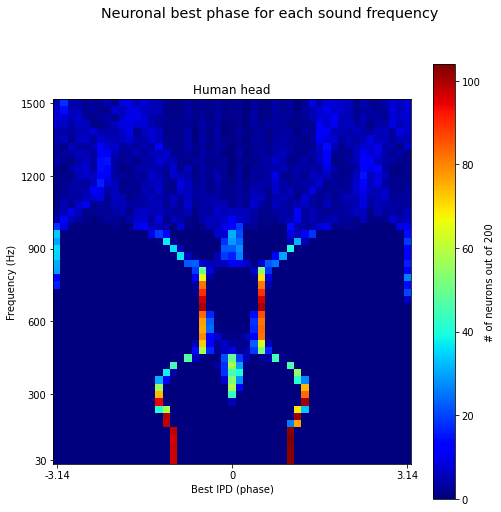

In [236]:
fig2, ax2 = plt.subplots(figsize=(8,8))
im2 = ax2.imshow(np.flip(x_50), cmap='jet',
               aspect='equal', interpolation = 'none', interpolation_stage='data')
ax2.set_xticks([0.,  24.,  48.], labels=[-3.14, 0, 3.14], minor=False)
ax2.set_yticks([0., 10., 20., 30., 40., 49.], labels=[1500, 1200, 900, 600, 300, 30])
ax2.set_xlabel('Best IPD (phase)')
ax2.set_ylabel('Frequency (Hz)')
ax2.set_title('Human head')
fig2.suptitle('Neuronal best phase for each sound frequency', fontsize='x-large')
fig2.colorbar(im2, label='# of neurons out of 200')

In [239]:
fig2.savefig('FI_neural-Human-2', transparent=True, dpi=300)

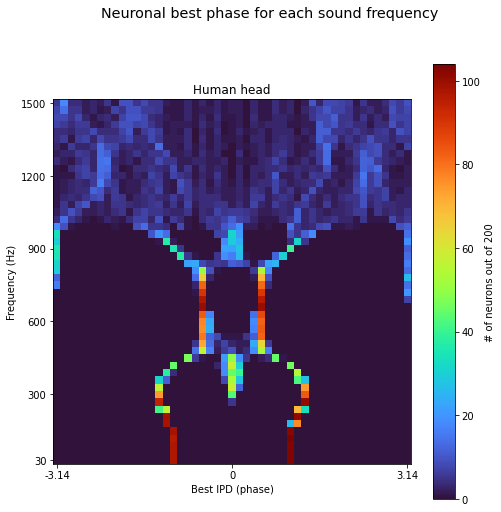

In [241]:
fig3, ax3 = plt.subplots(figsize=(8,8))
im3 = ax3.imshow(np.flip(x_50), cmap='turbo',
               aspect='equal', interpolation = 'none', interpolation_stage='data')
ax3.set_xticks([0.,  24.,  48.], labels=[-3.14, 0, 3.14], minor=False)
ax3.set_yticks([0., 10., 20., 30., 40., 49.], labels=[1500, 1200, 900, 600, 300, 30])
ax3.set_xlabel('Best IPD (phase)')
ax3.set_ylabel('Frequency (Hz)')
ax3.set_title('Human head')
fig3.suptitle('Neuronal best phase for each sound frequency', fontsize='x-large')
fig3.colorbar(im3, label='# of neurons out of 200')

In [242]:
fig3.savefig('FI_neural-Human-3', transparent=True, dpi=300)